In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/

%cd C247_Project
%ls -a

Mounted at /content/drive
/content/drive/MyDrive
/content/drive/MyDrive/C247_Project
 AngleEstimationTutorial.ipynb   dichasus/   models/              utils/
'Dataset Links.gdoc'             doatools/  'Papers from IEEE'/
 Data_Sets/                      .git/       rad_sdk/


In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

from utils.dichasusAoAFunctions import *
from models.AOA_CNN import *
from models.AOA_CNN_syn import *
from models.AOA_RNN_syn import *
from models.AOA_RNN import *
from models.AOA_NN import *
from models.MUSIC_AOA import *
from utils.Dichacus_Antenna_Cal import *

In [3]:
# Initalize Models to be used Later
CNN = AOA_CNN_SYN(input_dim = (32,32,2), num_activation_layers=2,activation_function="relu", dropout_rate = 0.35, num_units_in_layer=32)
# CNN_COV = AOA_CNN_SYN(input_dim = (32,32,2), num_activation_layers=2,activation_function="elu", dropout_rate = 0.25, num_units_in_layer=16)
#RNN = AOA_RNN_SYN(input_dim = (32,32,2), num_activation_layers=2,activation_function="relu", dropout_rate = 0.35)
#RNN_COV = AOA_RNN_SYN(input_dim = (32,32,2), num_activation_layers=2,activation_function="relu", dropout_rate = 0.35)
#RNN2 = AOA_RNN_SYN(input_dim = (32,32,2), num_activation_layers=2,activation_function="relu", dropout_rate = 0.35, RNN_Type="GRU")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        608       
                                                                 
 batch_normalization (BatchN  (None, 30, 30, 32)       120       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 30, 30, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 30, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 batch_normalization_1 (Batc  (None, 15, 15, 32)       6

In [4]:
import pickle
with open('Data_Sets/sim_7_ula_train_data.pkl', 'rb') as fp:
    train_data = pickle.load(fp)
    print('Dictionary Loaded')
with open('Data_Sets/sim_7_ula_val_data.pkl', 'rb') as fp:
    val_data = pickle.load(fp)
    print('Dictionary Loaded')

del fp

Dictionary Loaded
Dictionary Loaded


In [5]:
train_examples = train_data['Y']
train_labels = train_data['AoA']
train_dataset = tf.data.Dataset.from_tensor_slices((train_examples, train_labels, train_data['SNR'], train_data['Ry'], train_data['Rs'], train_data['S']))

val_examples = val_data['Y']
val_labels = val_data['AoA']
val_dataset = tf.data.Dataset.from_tensor_slices((val_examples, val_labels, val_data['SNR'], val_data['Ry'], val_data['Rs'], val_data['S']))
del train_data, val_data, train_examples, train_labels, val_examples, val_labels 


Batch Size: 128
Epoch 1/75
94/94 [==============================] - 21s 79ms/step - loss: 0.7248 - val_loss: 0.7785
Epoch 2/75
94/94 [==============================] - 5s 55ms/step - loss: 0.4281 - val_loss: 0.6063
Epoch 3/75
94/94 [==============================] - 8s 83ms/step - loss: 0.4141 - val_loss: 0.4692
Epoch 4/75
94/94 [==============================] - 5s 55ms/step - loss: 0.4063 - val_loss: 0.4150
Epoch 5/75
94/94 [==============================] - 7s 72ms/step - loss: 0.2896 - val_loss: 0.8238
Epoch 6/75
94/94 [==============================] - 5s 55ms/step - loss: 0.1645 - val_loss: 1.0790
Epoch 7/75
94/94 [==============================] - 10s 105ms/step - loss: 0.1494 - val_loss: 0.5679
Epoch 8/75
94/94 [==============================] - 7s 71ms/step - loss: 0.1428 - val_loss: 0.5342
Epoch 9/75
94/94 [==============================] - 5s 56ms/step - loss: 0.1350 - val_loss: 0.2078
Epoch 10/75
94/94 [==============================] - 5s 55ms/step - loss: 0.1296 - val_lo

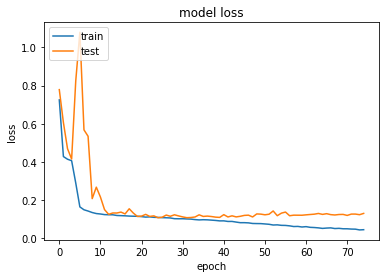

In [6]:
def get_feature_mapping_new(chunksize = 32):
	def compute_features_new(train_examples, angle, SNR, Ry, Rs, S):
		# print(train_examples.shape, angle.shape)
		assert(train_examples.shape[1] % chunksize == 0)
		featurecount = train_examples.shape[1] // chunksize
		csi_averaged = tf.stack([tf.math.reduce_mean(train_examples[:, (chunksize * s):(chunksize * (s + 1)), :], axis = 1) for s in range(featurecount)], axis = 1)
		return csi_averaged, angle, SNR, Ry, Rs, S
	return compute_features_new

train_dataset_new = train_dataset.map(get_feature_mapping_new(16))
val_dataset_new = val_dataset.map(get_feature_mapping_new(16))
#model = AOA_CNN(input_dim = (4,512), num_activation_layers=2,activation_function="relu", use_conv=True)
# model2 = AOA_RNN(input_dim = (4,512,2), num_activation_layers=3,activation_function="relu", type="LSTM")

batch_sizes = [64, 128, 256, 512]
batch_sizes = [128]
epochs = 75
for b in batch_sizes:
	CNN.train(train_dataset_new, val_dataset_new, batch_size= b, epochs_in = epochs, use_cov=True)
	#RNN.train(train_dataset_new, val_dataset_new, batch_size= b, epochs_in = epochs)
	#RNN2.train(train_dataset_new, val_dataset_new, batch_size= b, epochs_in = epochs)
	#CNN_COV.train(train_dataset_new, val_dataset_new, batch_size= b, epochs_in = epochs, use_cov=True)
	#RNN_COV.train(train_dataset_new, val_dataset_new, batch_size= b, epochs_in = epochs, use_cov=True)
	
	# model.train(train_dataset, val_dataset, batch_size= b)
# batch_sizes = [32, 64, 256, 512, 1024]
# for b in batch_sizes:
# 	model2.train(training_set_features, test_set_features, batch_size= b)

In [8]:
import doatools.model as doamodel
import doatools.estimation as estimation

d0 = 1/2
# ura = doamodel.UniformRectangularArray(4,8, 0.5)
ura = doamodel.UniformLinearArray(32, d0)
# grid = estimation.FarField1DSearchGrid(start=-np.pi/4, stop=np.pi/4)
grid = estimation.FarField1DSearchGrid()

outputs_CNN = CNN.test(val_dataset_new, use_cov=True)
#outputs_RNN = RNN.test(val_dataset_new)
#outputs_RNN_GRU = RNN2.test(val_dataset_new)
# outputs_CNN_COV = CNN_COV.test(val_dataset_new, use_cov=True)
#outputs_RNN_COV = RNN_COV.test(val_dataset_new, use_cov=True)
outputs_MUSIC = Calculate_MUSIC_Estimates(ura, grid, 1.0, val_dataset_new)

4/4 [==============================] - 0s 3ms/step


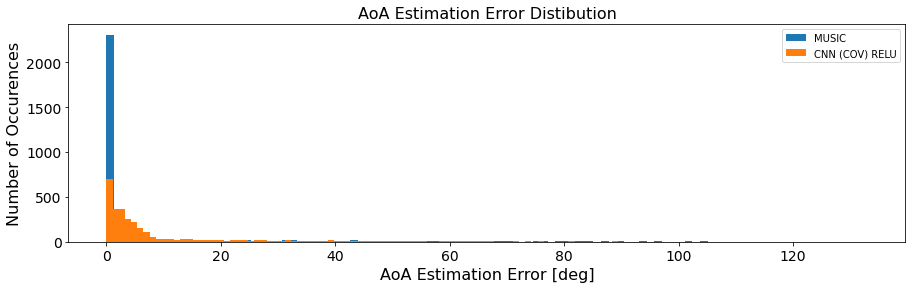

In [9]:
test_outputs = outputs_CNN
predicted_angles = test_outputs['predictedangles']
true_angles = test_outputs['true_angles']
SNR = test_outputs['SNR']
errors_abs_deg = test_outputs['errors_abs_deg'] 

test_outputs_mus = outputs_MUSIC
predicted_angles_mus = test_outputs_mus['predictedangles']
true_angles_mus = test_outputs_mus['true_angles']
SNR_mus = test_outputs_mus['SNR']
errors_abs_deg_mus = test_outputs_mus['errors_abs_deg'] 

# test_outputs_RNN = outputs_RNN
#predicted_angles_RNN = test_outputs_RNN['predictedangles']
#true_angles_RNN = test_outputs_RNN['true_angles']
#SNR_RNN = test_outputs_RNN['SNR']
#errors_abs_deg_RNN = test_outputs_RNN['errors_abs_deg'] 

#test_outputs_RNN2 = outputs_RNN_GRU
#predicted_angles_RNN2 = test_outputs_RNN2['predictedangles']
#true_angles_RNN2 = test_outputs_RNN2['true_angles']
#SNR_RNN2 = test_outputs_RNN2['SNR']
#errors_abs_deg_RNN2 = test_outputs_RNN2['errors_abs_deg'] 

# test_outputs_CNN_COV = outputs_CNN_COV
# predicted_angles_CNN_COV = test_outputs_CNN_COV['predictedangles']
# true_angles_CNN_COV = test_outputs_CNN_COV['true_angles']
# SNR_CNN_COV = test_outputs_CNN_COV['SNR']
# errors_abs_deg_CNN_COV = test_outputs_CNN_COV['errors_abs_deg'] 

#test_outputs_RNN_COV = outputs_RNN_COV
#predicted_angles_RNN_COV = test_outputs_RNN_COV['predictedangles']
#true_angles_RNN_COV= test_outputs_RNN_COV['true_angles']
#SNR_RNN_COV = test_outputs_RNN_COV['SNR']
#errors_abs_deg_RNN_COV = test_outputs_RNN_COV['errors_abs_deg'] 

plt.figure(figsize=(15, 4))
plt.title("AoA Estimation Error Distibution", fontsize = 16)
plt.xlabel("AoA Estimation Error [deg]", fontsize = 16)
plt.ylabel("Number of Occurences", fontsize = 16)
plt.tick_params(axis = "both", labelsize = 14)

plt.hist(errors_abs_deg_mus, bins = 100, label = "MUSIC")
plt.hist(errors_abs_deg, bins = 100, label = "CNN (COV) RELU")
#plt.hist(errors_abs_deg_RNN, bins = 100, label = "CNN+LSTM")
#plt.hist(errors_abs_deg_RNN2, bins = 100, label = "CNN+GRU")
# plt.hist(errors_abs_deg_CNN_COV, bins = 100, label = "CNN (COV) ELU")
#plt.hist(errors_abs_deg_RNN_COV, bins = 100, label = "CNN+LSTM (COV)")
plt.legend()
plt.show()

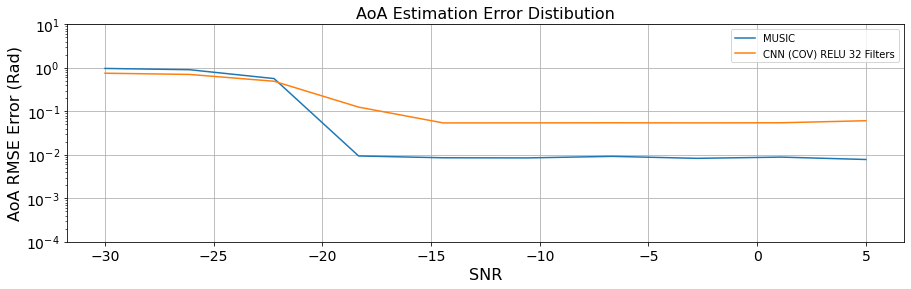

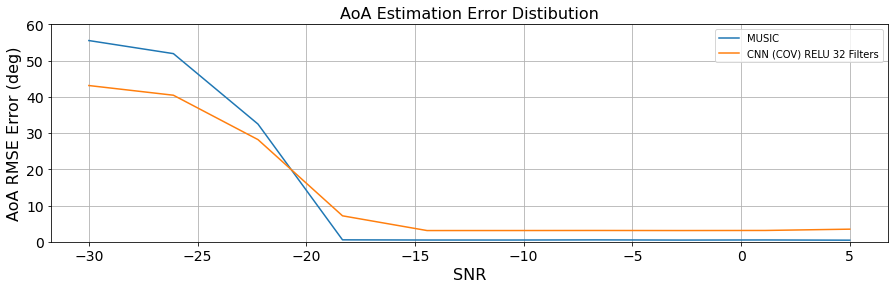

In [10]:
unique_SNR_CNN = np.unique(SNR)
RMSE_MUS = []
RMSE_CNN = []
RMSE_RNN = []
RMSE_RNN2 = []
RMSE_CNN_COV = []
RMSE_RNN_COV = []
for snr in unique_SNR_CNN:
  ind = np.where(SNR == snr)[0]
  # print(ind)
  RMSE_CNN.append(np.sqrt(np.sum((true_angles[ind] - predicted_angles[ind])**2) / true_angles[ind].shape[0]))

unique_SNR_MUS = np.unique(SNR_mus)
for snr in unique_SNR_MUS:
  ind = np.where(SNR_mus == snr)[0]
  RMSE_MUS.append(np.sqrt(np.sum((true_angles_mus[ind] - predicted_angles_mus[ind])**2) / true_angles_mus[ind].shape[0]))

#unique_SNR_RNN = np.unique(SNR_RNN)
#for snr in unique_SNR_RNN:
#  ind = np.where(SNR_RNN == snr)[0]
#  RMSE_RNN.append(np.sqrt(np.sum((true_angles_RNN[ind] - predicted_angles_RNN[ind])**2) / true_angles_RNN[ind].shape[0]))

#unique_SNR_RNN2 = np.unique(SNR_RNN2)
#for snr in unique_SNR_RNN2:
#  ind = np.where(SNR_RNN2 == snr)[0]
#  RMSE_RNN2.append(np.sqrt(np.sum((true_angles_RNN2[ind] - predicted_angles_RNN2[ind])**2) / true_angles_RNN2[ind].shape[0]))

# unique_SNR_CNN_COV = np.unique(SNR_CNN_COV)
# for snr in unique_SNR_CNN_COV:
#  ind = np.where(SNR_CNN_COV == snr)[0]
#  RMSE_CNN_COV.append(np.sqrt(np.sum((true_angles_CNN_COV[ind] - predicted_angles_CNN_COV[ind])**2) / true_angles_CNN_COV[ind].shape[0]))

#unique_SNR_RNN_COV = np.unique(SNR_RNN_COV)
#for snr in unique_SNR_RNN_COV:
#  ind = np.where(SNR_RNN_COV == snr)[0]
#  RMSE_RNN_COV.append(np.sqrt(np.sum((true_angles_RNN_COV[ind] - predicted_angles_RNN_COV[ind])**2) / true_angles_RNN_COV[ind].shape[0]))

RMSE_MUS = np.hstack(RMSE_MUS)
RMSE_CNN = np.hstack(RMSE_CNN)
#RMSE_RNN = np.hstack(RMSE_RNN)
#RMSE_RNN2 = np.hstack(RMSE_RNN2)
#RMSE_CNN_COV = np.hstack(RMSE_CNN_COV)
#RMSE_RNN_COV = np.hstack(RMSE_RNN_COV)

plt.figure(figsize=(15, 4))
plt.title("AoA Estimation Error Distibution", fontsize = 16)
plt.xlabel("SNR", fontsize = 16)
plt.ylabel("AoA RMSE Error (Rad)", fontsize = 16)
plt.tick_params(axis = "both", labelsize = 14)

plt.semilogy(unique_SNR_MUS, RMSE_MUS, label = "MUSIC")
plt.semilogy(unique_SNR_CNN,  RMSE_CNN, label = "CNN (COV) RELU 32 Filters")
#plt.semilogy(unique_SNR_RNN, RMSE_RNN, label = "CNN+LSTM")
#plt.semilogy(unique_SNR_RNN2, RMSE_RNN2, label = "CNN+GRU")
#plt.semilogy(unique_SNR_CNN_COV,  RMSE_CNN_COV, label = "CNN (COV) RELU 16 Filters")
#plt.semilogy(unique_SNR_RNN_COV, RMSE_RNN_COV, label = "CNN+LSTM (COV)")
plt.ylim( (pow(10,-4),pow(10,1)) )
plt.grid()
plt.legend()
plt.show()

plt.figure(figsize=(15, 4))
plt.title("AoA Estimation Error Distibution", fontsize = 16)
plt.xlabel("SNR", fontsize = 16)
plt.ylabel("AoA RMSE Error (deg)", fontsize = 16)
plt.tick_params(axis = "both", labelsize = 14)

plt.plot(unique_SNR_MUS, np.rad2deg(RMSE_MUS), label = "MUSIC")
plt.plot(unique_SNR_CNN,  np.rad2deg(RMSE_CNN), label = "CNN (COV) RELU 32 Filters")
#plt.semilogy(unique_SNR_RNN, RMSE_RNN, label = "CNN+LSTM")
#plt.semilogy(unique_SNR_RNN2, RMSE_RNN2, label = "CNN+GRU")
#plt.plot(unique_SNR_CNN_COV,  np.rad2deg(RMSE_CNN_COV), label = "CNN (COV) RELU 16 Filters")
#plt.semilogy(unique_SNR_RNN_COV, RMSE_RNN_COV, label = "CNN+LSTM (COV)")
plt.ylim( 0,60 )
plt.grid()
plt.legend()
plt.show()